# Forecasting Sales Data

This notebook provides a comprehensive analysis and forecasting of sales data.

## Importing Necessary Libraries

Importing essential libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

## Load the data

In [2]:
file_path = 'daily_sales_per_store.csv'
df = pd.read_csv(file_path)
df

,date,sales
0,2013-01-01,1316
1,2013-01-02,1264
2,2013-01-03,1305
3,2013-01-04,1452
4,2013-01-05,1499
...,...,...
1821,2017-12-27,1837
1822,2017-12-28,1951
1823,2017-12-29,2116
1824,2017-12-30,2304


## Data Cleaning and add features

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1826 non-null   object
 1   sales   1826 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.7+ KB


In [4]:
df.set_index('date', inplace=True)

In [7]:
all_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

missing_days = all_days.difference(df.index)

if missing_days.empty:
    print("All days exist.")
else:
    print(f"Missing days : {missing_days}")

All days exist.


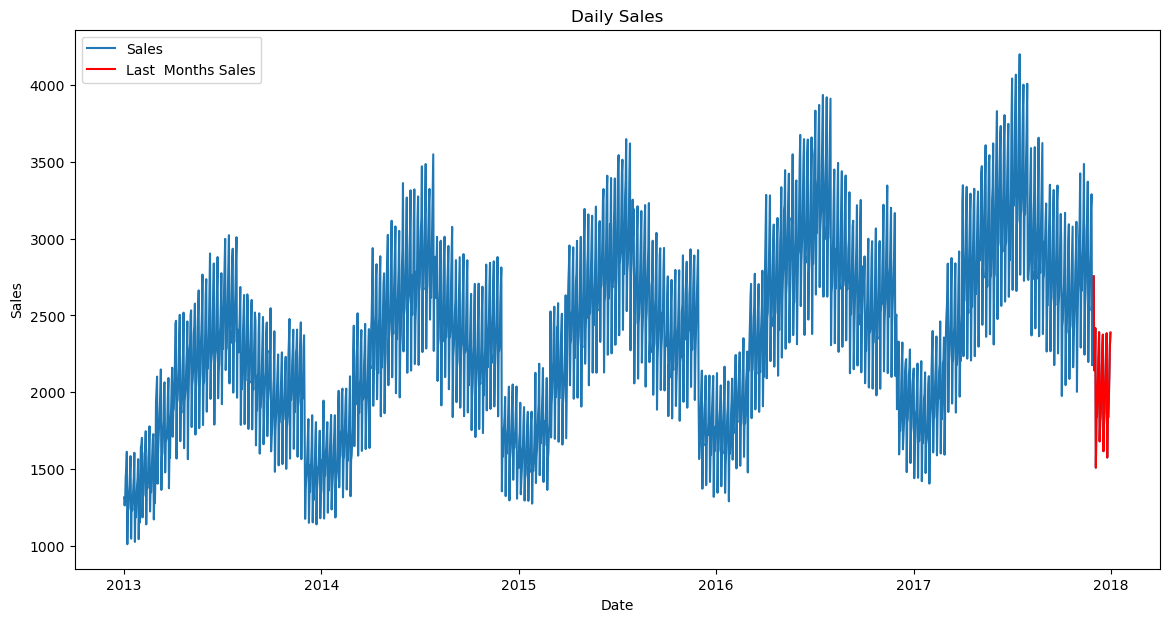

In [6]:
# Convert 'date' column to datetime
df.index = pd.to_datetime(df.index)

# Aggregate sales by date
daily_sales = df.groupby(df.index)['sales'].sum().reset_index()

# Identify the last n months
last_n_months = daily_sales['date'].max() - pd.DateOffset(months=1)

train = df.loc[df.index <= last_n_months]
test = df.loc[df.index > last_n_months]

# Plot the sales data
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Sales')

# Highlight the last n months
highlight = daily_sales[daily_sales['date'] >= last_n_months]
plt.plot(highlight['date'], highlight['sales'], label='Last  Months Sales', color='red')

plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### We need to add features

In [693]:
def create_features(df):
    df = df.copy()  
    
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    ''' df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_monday'] = (df['dayofweek'] == 0).astype(int)
    df['is_week_start'] = df['dayofweek'].isin([0, 1]).astype(int)
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_year_start'] = df.index.is_year_start.astype(int)
    df['is_year_end'] = df.index.is_year_end.astype(int)'''
    
    return df

df = create_features(df)

In [694]:
df

,sales,dayofweek,quarter,month,year,dayofyear,weekofyear
date,,,,,,,
2013-01-01,1316,1,1,1,2013,1,1
2013-01-02,1264,2,1,1,2013,2,1
2013-01-03,1305,3,1,1,2013,3,1
2013-01-04,1452,4,1,1,2013,4,1
2013-01-05,1499,5,1,1,2013,5,1
...,...,...,...,...,...,...,...
2017-12-27,1837,2,4,12,2017,361,52
2017-12-28,1951,3,4,12,2017,362,52
2017-12-29,2116,4,4,12,2017,363,52


In [695]:
def create_plot(x_,y_):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.bar(df[x_], df[y_], color='blue')
    ax.set_title(f'{y_} by {x_}')
    ax.set_xlabel(x_)
    ax.set_ylabel(y_)
    plt.show()

## Data analysis and visualization

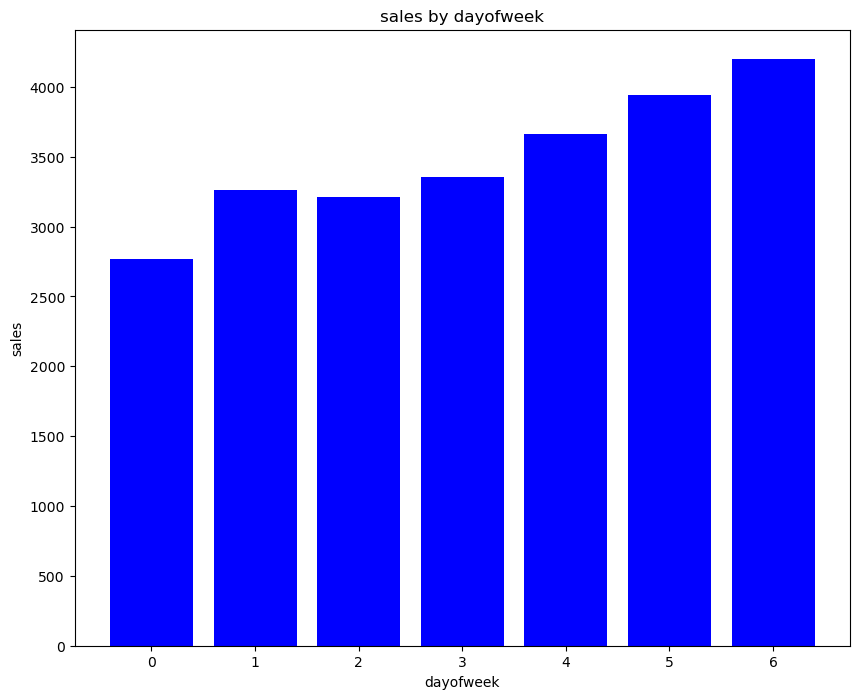

In [696]:
create_plot('dayofweek','sales')

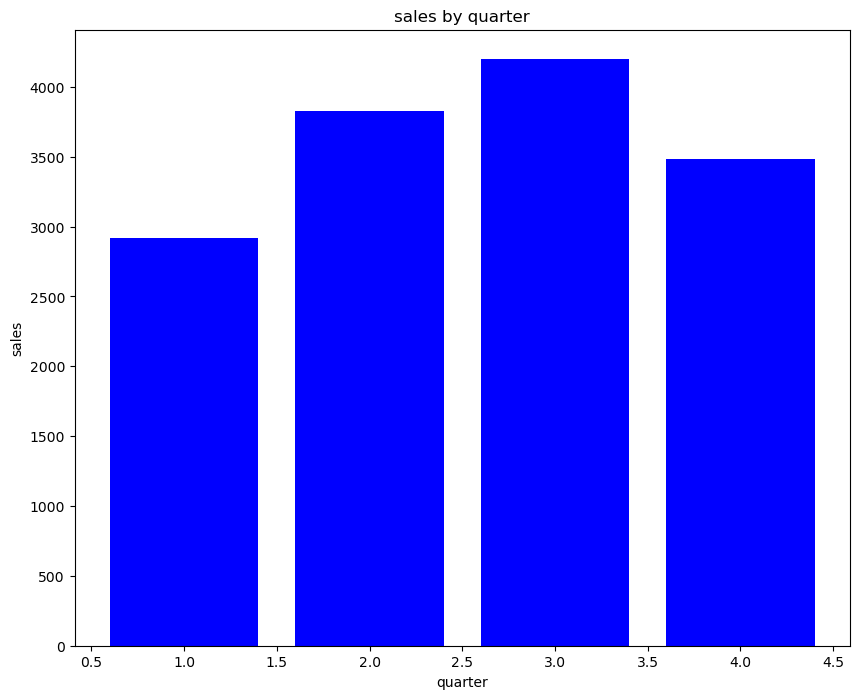

In [697]:
create_plot('quarter','sales')

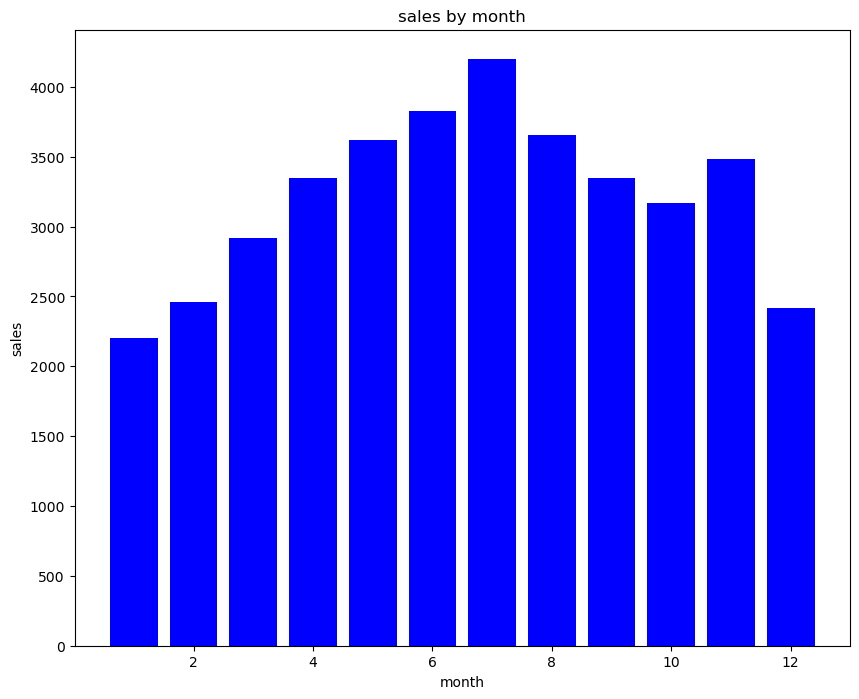

In [698]:
create_plot('month','sales')

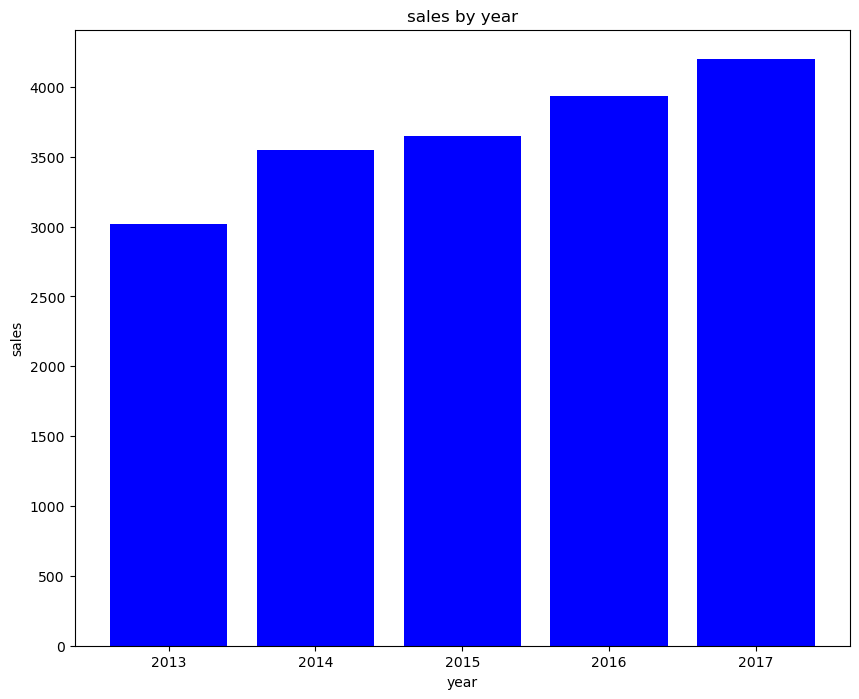

In [699]:
create_plot('year','sales')

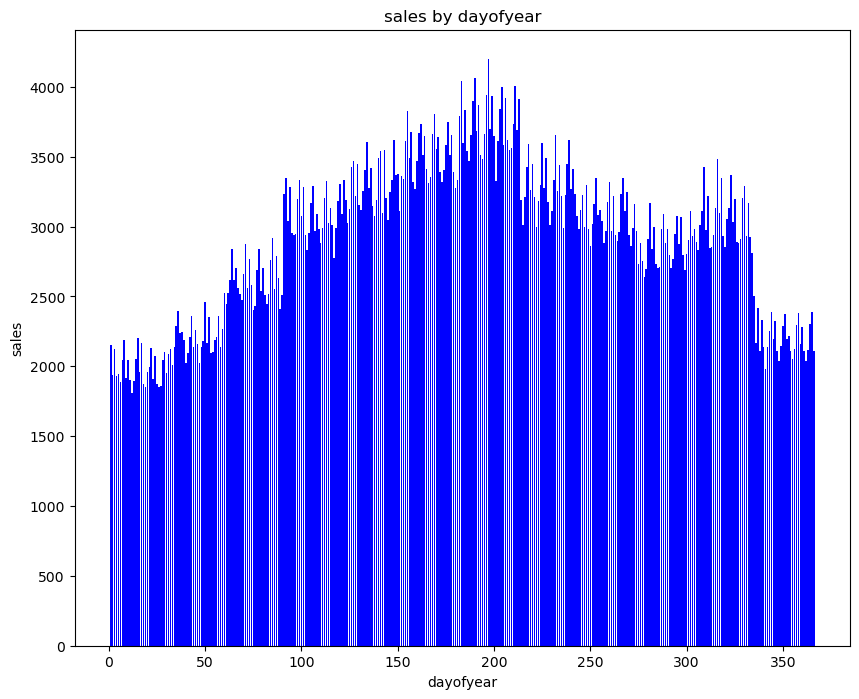

In [700]:
create_plot('dayofyear','sales')

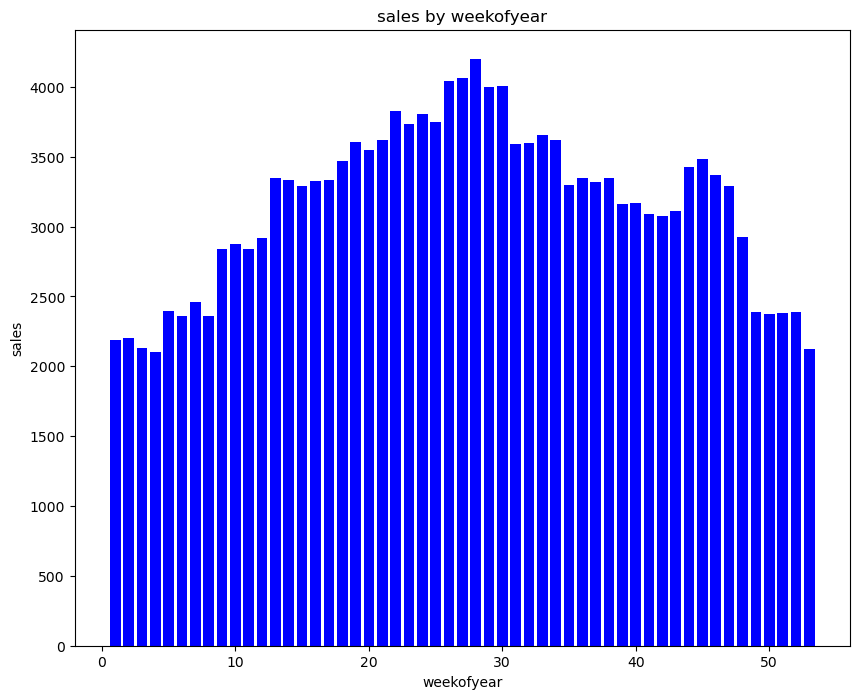

In [701]:
create_plot('weekofyear','sales')

## Splitting Data into Training and Test Sets

Splitting the data into training and test sets to evaluate model performance.

In [702]:
train = create_features(train)
test = create_features(test)

In [703]:
#FEATURES = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear'] # 68.35
#FEATURES = ['dayofweek','quarter','month','year','dayofyear','weekofyear'] # Without dayofmonth 68.29 
#FEATURES = ['dayofweek','quarter','month','year','dayofyear','weekofyear', 'is_weekend'] # Without dayofmonth & add is_weekend(0 importance) 68.29
'''FEATURES = [
    'dayofweek',
    'quarter',
    'month',
    'year',
    'dayofyear',
    'weekofyear',
    'is_weekend',
    'is_month_start',
    'is_month_end',
    'is_quarter_start',
    'is_quarter_end',
    'is_year_start',
    'is_year_end',
    'is_monday',
    'is_week_start'
]'''
FEATURES = [
    'dayofweek',
    'quarter',
    'month',
    'year',
    'dayofyear',
    'weekofyear',
]
TARGET = 'sales'


In [704]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [705]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Machine Learning models

### Linear Regression 

In [706]:
lnr = LinearRegression()
lnr.fit(X_train, y_train)

y_train_pred = lnr.predict(X_train)
y_test_pred = lnr.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [707]:
print(f'Linear Regression - Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}, Train MAPE: {train_mape:.2f}%, Train R²: {train_r2:.2f}')
print(f'Linear Regression - Test RMSE: {test_rmse:.2f}, Test MAE: {test_mae:.2f}, Test MAPE: {test_mape:.2f}%, Test R²: {test_r2:.2f}')

Linear Regression - Train RMSE: 414.82, Train MAE: 340.73, Train MAPE: 15.65%, Train R²: 0.50
Linear Regression - Test RMSE: 938.44, Test MAE: 936.39, Test MAPE: 46.72%, Test R²: -12.15


#### Evaluating the Model

Evaluating the model's performance using RMSE.

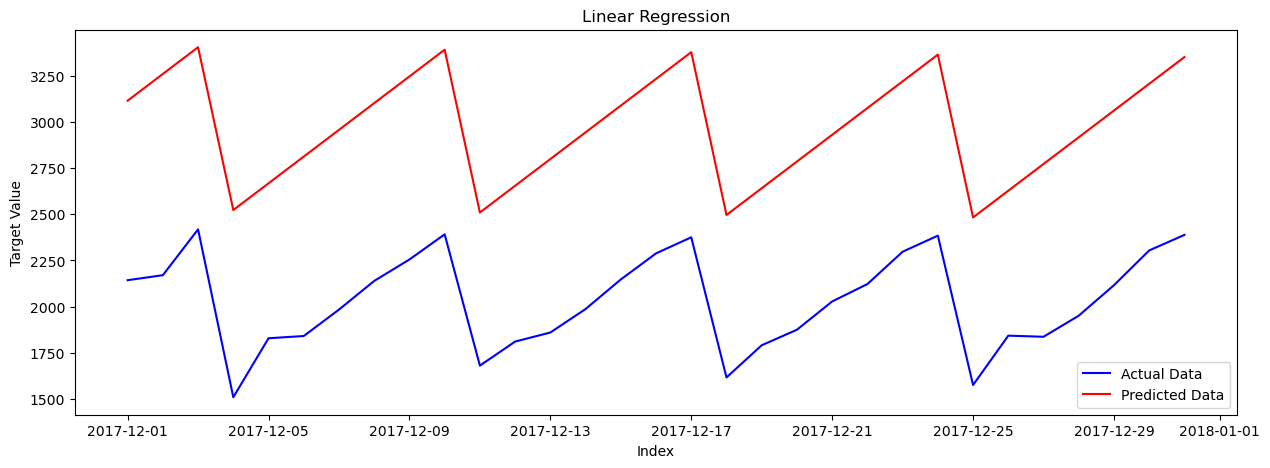

In [708]:
plt.figure(figsize=(15, 5))

plt.plot(test.index, y_test, label='Actual Data', color='blue')
plt.plot(test.index, y_test_pred, label='Predicted Data', color='red')

plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Linear Regression')
plt.legend()
plt.show()

### Polynomial Regression 

In [709]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [710]:
print(f'Polynomial - Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}, Train MAPE: {train_mape:.2f}%, Train R²: {train_r2:.2f}')
print(f'Polynomial - Test RMSE: {test_rmse:.2f}, Test MAE: {test_mae:.2f}, Test MAPE: {test_mape:.2f}%, Test R²: {test_r2:.2f}')

Polynomial - Train RMSE: 162.40, Train MAE: 132.35, Train MAPE: 5.73%, Train R²: 0.92
Polynomial - Test RMSE: 246.52, Test MAE: 217.73, Test MAPE: 10.27%, Test R²: 0.09


#### Evaluating the Model

Evaluating the model's performance using RMSE.

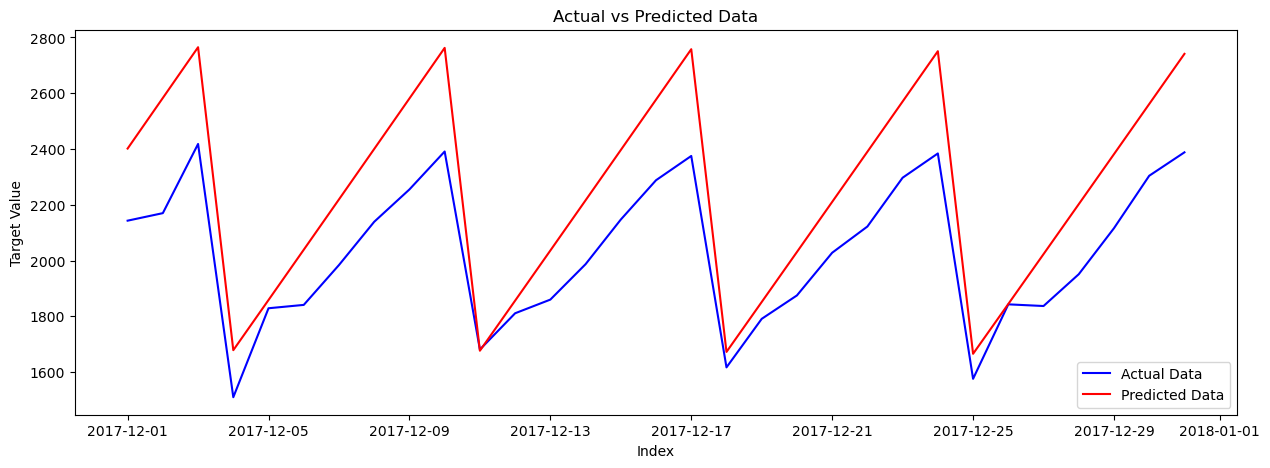

In [711]:
plt.figure(figsize=(15, 5))

plt.plot(test.index, y_test, label='Actual Data', color='blue')
plt.plot(test.index, y_test_pred, label='Predicted Data', color='red')

plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Data')
plt.legend()
plt.show()

### Gradient Boosting Search

In [712]:
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.01,
    subsample=0.8
)

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.03],
    'n_estimators': [500, 1000, 1500],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.9}


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 1500, 'subsample': 0.9}


### xgboost 

In [713]:
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=best_params['n_estimators'],
    early_stopping_rounds=50,
    objective='reg:squarederror',
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample']
)
'''
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.01,
    subsample=0.8
)
'''
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

test['prediction'] = reg.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

[0]	validation_0-rmse:2368.65694	validation_1-rmse:1995.09865
[100]	validation_0-rmse:198.48714	validation_1-rmse:106.18938
[126]	validation_0-rmse:139.21345	validation_1-rmse:150.70441


#### Evaluating the Model

Evaluating the model's performance using RMSE.

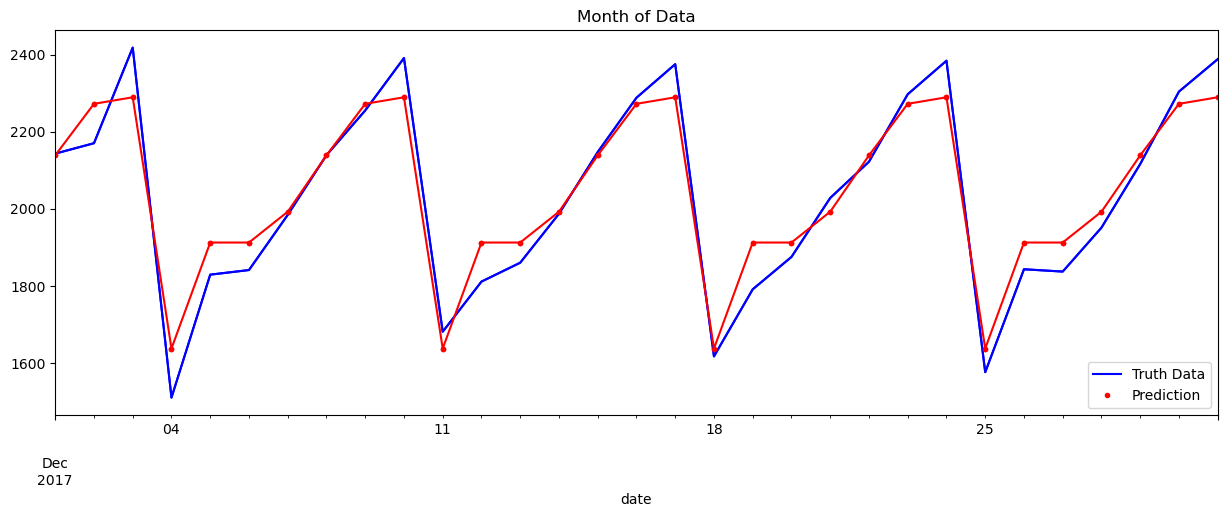

In [714]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df.loc[(df.index > last_n_months), 'sales'] \
    .plot(figsize=(15, 5), title='Month of Data', color='blue')
df.loc[(df.index > last_n_months), 'prediction'] \
    .plot(style='.', ax=ax, color='red')
df.loc[(df.index > last_n_months) , 'sales'].plot(ax=ax, color='blue')
df.loc[(df.index > last_n_months), 'prediction'].plot(style='.-', ax=ax, color='red')

plt.legend(['Truth Data', 'Prediction'])

plt.show()

In [715]:
print(f'XGBRegressor - Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}, Train MAPE: {train_mape:.2f}%, Train R²: {train_r2:.2f}')
print(f'XGBRegressor - Test RMSE: {test_rmse:.2f}, Test MAE: {test_mae:.2f}, Test MAPE: {test_mape:.2f}%, Test R²: {test_r2:.2f}')

XGBRegressor - Train RMSE: 311.54, Train MAE: 240.11, Train MAPE: 9.02%, Train R²: 0.72
XGBRegressor - Test RMSE: 68.06, Test MAE: 55.14, Test MAPE: 2.79%, Test R²: 0.93


In [716]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test.groupby([test.index.date])['error'].mean().sort_values(ascending=False).head(30)

2017-12-03    128.847900
2017-12-04    127.280396
2017-12-19    121.342407
2017-12-02    102.224365
2017-12-10    101.847900
2017-12-12    101.342407
2017-12-31     98.847900
2017-12-24     94.847900
2017-12-17     85.847900
2017-12-05     83.342407
2017-12-27     75.342407
2017-12-06     71.342407
2017-12-26     69.342407
2017-12-25     61.280396
2017-12-13     52.342407
2017-12-11     43.719604
2017-12-28     41.273804
2017-12-20     37.342407
2017-12-21     35.726196
2017-12-30     31.775635
2017-12-23     24.775635
2017-12-29     22.418945
2017-12-18     20.280396
2017-12-09     17.224365
2017-12-22     16.418945
2017-12-16     15.775635
2017-12-15      8.581055
2017-12-07      8.273804
2017-12-14      5.273804
2017-12-01      4.581055
Name: error, dtype: float64

## Feature importances

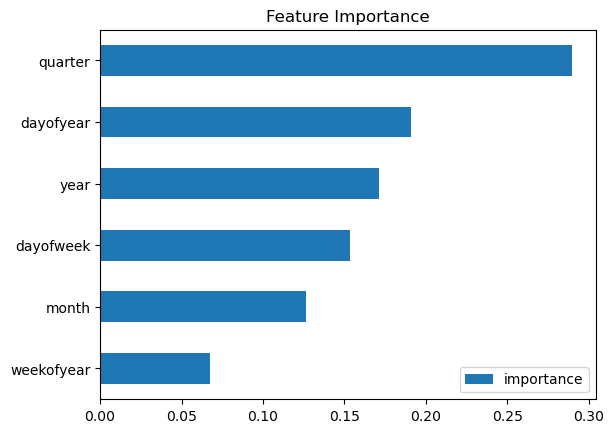

In [717]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance')

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [718]:
'''import sys
print(sys.version)


import joblib
joblib.dump(reg,"xgboost_for_ forecasting.pkl")

file = joblib.load('xgboost_for_ forecasting.pkl')

d = pd.to_datetime('2018-01-01')
x2 = pd.DataFrame(index=[d])
x2=create_features(x2)
x3=x2[FEATURES]

prediction = reg.predict(x3)[0]

prediction'''

'import sys\nprint(sys.version)\n\n\nimport joblib\njoblib.dump(reg,"xgboost_for_ forecasting.pkl")\n\nfile = joblib.load(\'xgboost_for_ forecasting.pkl\')\n\nd = pd.to_datetime(\'2018-01-01\')\nx2 = pd.DataFrame(index=[d])\nx2=create_features(x2)\nx3=x2[FEATURES]\n\nprediction = reg.predict(x3)[0]\n\nprediction'